In [1]:
import keras
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input
from keras.layers import Layer, Dense, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D

## Подготовка данных

### Обучающая выборка

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Размытые данные

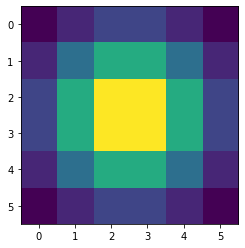

In [3]:
def gkern(kernlen=6, std=1.5):
    gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
    gkern2d = np.outer(gkern1d, gkern1d)
    return gkern2d/np.sum(gkern2d)

plt.imshow(gkern(6), interpolation='none')

X_train_blur = [0 for i in range(len(X_train))]
for i in range(len(X_train)):
    X_train_blur[i] = signal.convolve2d(X_train[i].reshape((28, 28)), gkern(10), mode='same')

X_train_blur = np.array(X_train_blur)

X_test_blur = [0 for i in range(len(X_test))]
for i in range(len(X_test)):
    X_test_blur[i] = signal.convolve2d(X_test[i].reshape((28, 28)), gkern(10), mode='same')
    
X_test_blur = np.array(X_test_blur)

X_train_blur = X_train_blur.reshape(len(X_train), 784)
X_test_blur = X_test_blur.reshape(len(X_test), 784)

### Зашумленные данные

In [4]:
noise_factor = 0.4
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

### Размытые зашумленные данные

In [5]:
X_train_blur_noisy = [0 for i in range(len(X_train))]
for i in range(len(X_train)):
    X_train_blur_noisy[i] = signal.convolve2d(X_train_noisy[i].reshape((28, 28)), gkern(10), mode='same')

X_train_blur_noisy = np.array(X_train_blur_noisy)

X_test_blur_noisy = [0 for i in range(len(X_test))]
for i in range(len(X_test)):
    X_test_blur_noisy[i] = signal.convolve2d(X_test_noisy[i].reshape((28, 28)), gkern(10), mode='same')
    
X_test_blur_noisy = np.array(X_test_blur_noisy)

X_train_blur_noisy = X_train_blur_noisy.reshape(len(X_train), 784)
X_test_blur_noisy = X_test_blur_noisy.reshape(len(X_test), 784)

### Зашумленные размытые данные

In [6]:
noise_factor = 0.15
X_train_noisy_blur = X_train_blur + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy_blur = X_test_blur + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy_blur = np.clip(X_train_noisy_blur, 0., 1.)
X_test_noisy_blur = np.clip(X_test_noisy_blur, 0., 1.)

###  Итоговая выборка

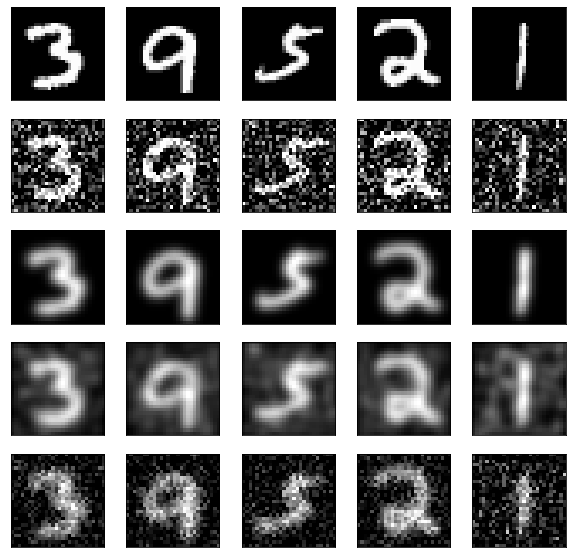

In [36]:
first = 500
n = 5
plt.figure(figsize=(10, 12))
for i in range(n):
    ax = plt.subplot(6, n, i+1)
    plt.imshow(X_test[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(6, n, i+n+1)
    plt.imshow(X_test_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+2*n+1)
    plt.imshow(X_test_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+3*n+1)
    plt.imshow(X_test_blur_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+4*n+1)
    plt.imshow(X_test_noisy_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

# Автоэнкодеры

## Полносвязный автоэнкодер

### Модель

In [8]:
input_size = 784
hidden_size = 64
output_size = 784

x = Input(shape=(input_size,))
h = Dense(hidden_size, activation='relu')(x)
r = Dense(output_size, activation='sigmoid')(h)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

epochs = 5
batch_size = 128

### Восстановление изначальных данных

In [9]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1968 - val_loss: 0.1322
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1165 - val_loss: 0.1025
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0962 - val_loss: 0.0890
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0860 - val_loss: 0.0818
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0808 - val_loss: 0.0782


### Представление в скрытом пространстве

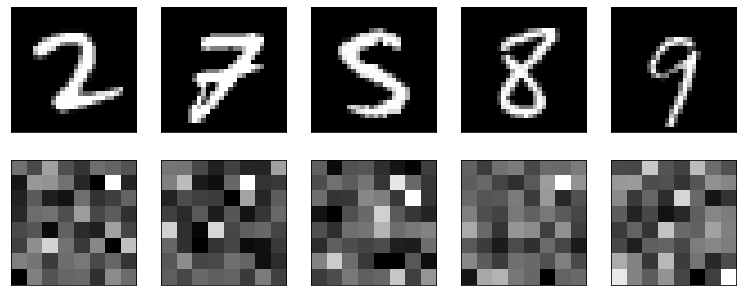

In [10]:
conv_encoder = Model(x, h)
encoded_imgs = conv_encoder.predict(X_test)

first = 467
n = 5
plt.figure(figsize=(13, 8))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(encoded_imgs[i].reshape(8, 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
decoded_imgs = autoencoder.predict(X_test)

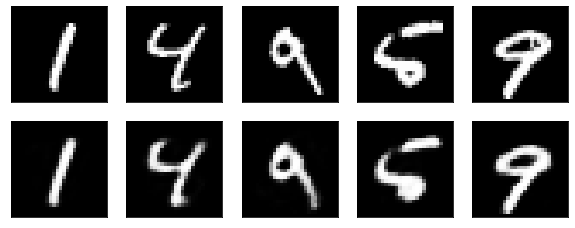

In [12]:
first = 5
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Удаление шума

In [13]:
history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1080 - val_loss: 0.1143
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1026 - val_loss: 0.1069
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1015 - val_loss: 0.1039
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1008 - val_loss: 0.1024
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1004 - val_loss: 0.0985


In [14]:
decoded_noisy_imgs = autoencoder.predict(X_test_noisy)

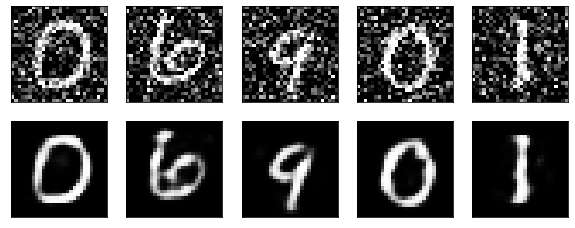

In [15]:
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Восстановление размытых данных

In [16]:
history = autoencoder.fit(X_train_blur, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1009 - val_loss: 0.1702
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0904 - val_loss: 0.2104
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0866 - val_loss: 0.2405
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0843 - val_loss: 0.2670
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.0827 - val_loss: 0.2919


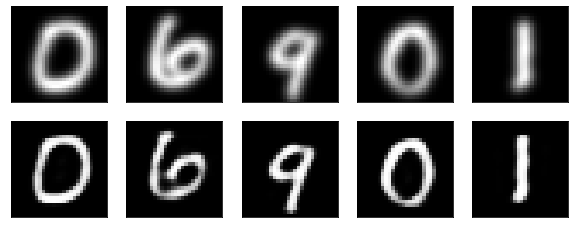

In [17]:
decoded_blur_imgs = autoencoder.predict(X_test_blur)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Восстановление размытых зашумленных данных

In [18]:
history = autoencoder.fit(X_train_blur_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1066 - val_loss: 0.3198
Epoch 2/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1047 - val_loss: 0.3265
Epoch 3/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1042 - val_loss: 0.3335
Epoch 4/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1038 - val_loss: 0.3386
Epoch 5/5
469/469 [==============================] - 2s 3ms/step - loss: 0.1034 - val_loss: 0.3461


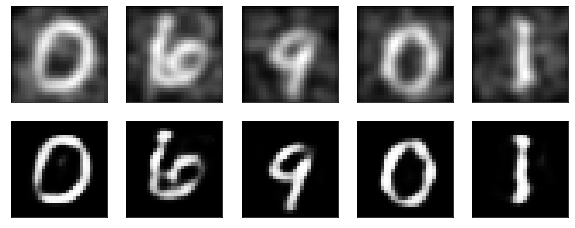

In [19]:
decoded_blur_noisy_imgs = autoencoder.predict(X_test_blur_noisy)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_blur_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_blur_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Восстановление зашумленных размытых данных

In [20]:
history = autoencoder.fit(X_train_noisy_blur, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1109 - val_loss: 0.2661
Epoch 2/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1066 - val_loss: 0.2414
Epoch 3/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1051 - val_loss: 0.2296
Epoch 4/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1044 - val_loss: 0.2233
Epoch 5/5
469/469 [==============================] - 1s 3ms/step - loss: 0.1041 - val_loss: 0.2229


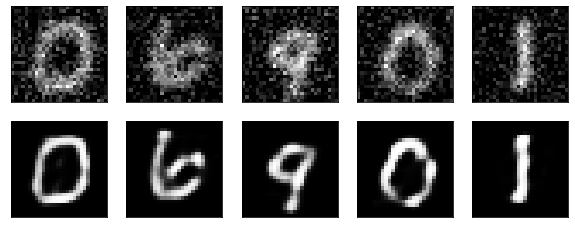

In [21]:
decoded_noisy_blur_imgs = autoencoder.predict(X_test_noisy_blur)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_noisy_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Сравнение восстановленных данных

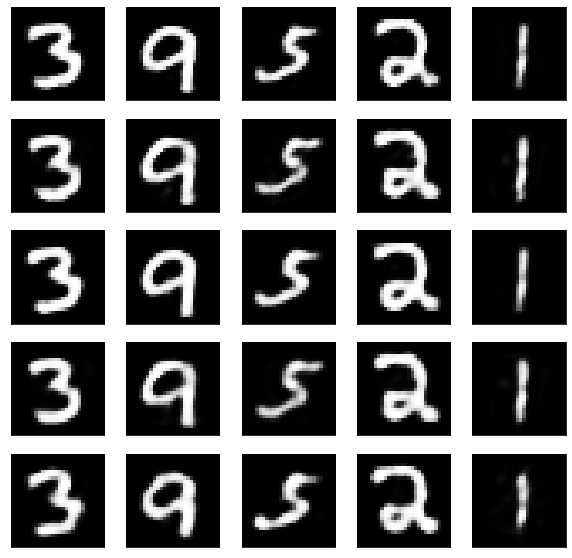

In [22]:
first = 500
n = 5
plt.figure(figsize=(10, 12))
for i in range(n):
    ax = plt.subplot(6, n, i+1)
    plt.imshow(decoded_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(6, n, i+n+1)
    plt.imshow(decoded_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+2*n+1)
    plt.imshow(decoded_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+3*n+1)
    plt.imshow(decoded_blur_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+4*n+1)
    plt.imshow(decoded_noisy_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Свёрточный автоэнкодер

### Подготовка данных

In [23]:
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))

X_train_blur = X_train_blur.reshape((len(X_train), 28, 28, 1))
X_test_blur = X_test_blur.reshape((len(X_test), 28, 28, 1))

X_train_noisy = X_train_noisy.reshape((len(X_train), 28, 28, 1))
X_test_noisy = X_test_noisy.reshape((len(X_test), 28, 28, 1))

X_train_blur_noisy = X_train_blur_noisy.reshape((len(X_train), 28, 28, 1))
X_test_blur_noisy = X_test_blur_noisy.reshape((len(X_test), 28, 28, 1))

X_train_noisy_blur = X_train_noisy_blur.reshape((len(X_train), 28, 28, 1))
X_test_noisy_blur = X_test_noisy_blur.reshape((len(X_test), 28, 28, 1))

### Модель

In [24]:
x = Input(shape=(28, 28, 1)) 

# Encoder
conv1_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
h = MaxPooling2D((2, 2), padding='same')(conv1_2)


# Decoder
conv2_1 = Conv2D(32, (3, 3), activation='relu', padding='same')(h)
up1 = UpSampling2D((2, 2))(conv2_1)
conv2_2 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up3 = UpSampling2D((2, 2))(conv2_2)
r = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)

autoencoder = Model(inputs=x, outputs=r)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

epochs = 1
batch_size = 128

### Восстановление изначальных данных

In [25]:
history = autoencoder.fit(X_train, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/2
469/469 [==============================] - 61s 129ms/step - loss: 0.1163 - val_loss: 0.0780
Epoch 2/2
469/469 [==============================] - 61s 129ms/step - loss: 0.0761 - val_loss: 0.0732


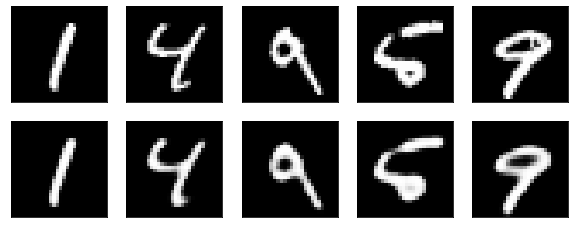

In [26]:
decoded_imgs = autoencoder.predict(X_test)
first = 5
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

### Удаление шума

In [27]:
history = autoencoder.fit(X_train_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/2
469/469 [==============================] - 61s 131ms/step - loss: 0.1094 - val_loss: 0.0817
Epoch 2/2
469/469 [==============================] - 59s 126ms/step - loss: 0.0975 - val_loss: 0.0787


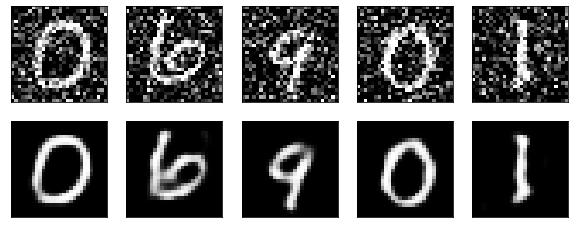

In [28]:
decoded_noisy_imgs = autoencoder.predict(X_test_noisy)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Восстановление размытых данных

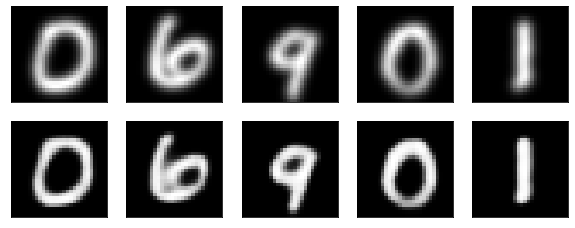

In [29]:
decoded_blur_imgs = autoencoder.predict(X_test_blur)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Восстановление размытых зашумленных данных

In [30]:
history = autoencoder.fit(X_train_blur_noisy, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/2
469/469 [==============================] - 59s 127ms/step - loss: 0.1054 - val_loss: 0.2674
Epoch 2/2
469/469 [==============================] - 62s 132ms/step - loss: 0.0987 - val_loss: 0.2764


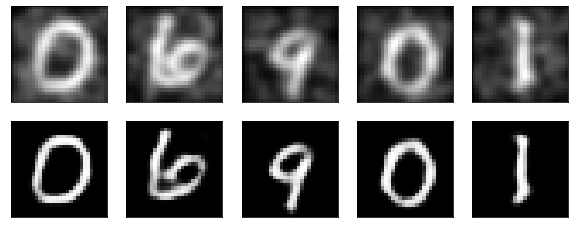

In [31]:
decoded_blur_noisy_imgs = autoencoder.predict(X_test_blur_noisy)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_blur_noisy[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_blur_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [32]:
history = autoencoder.fit(X_train_blur, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/2
469/469 [==============================] - 58s 123ms/step - loss: 0.0769 - val_loss: 0.3171
Epoch 2/2
469/469 [==============================] - 61s 131ms/step - loss: 0.0743 - val_loss: 0.3478


## Восстановление зашумленных размытых данных

In [33]:
history = autoencoder.fit(X_train_noisy_blur, X_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, X_test))

Epoch 1/3
469/469 [==============================] - 59s 126ms/step - loss: 0.0989 - val_loss: 0.2428
Epoch 2/3
469/469 [==============================] - 61s 130ms/step - loss: 0.0949 - val_loss: 0.2228
Epoch 3/3
469/469 [==============================] - 62s 131ms/step - loss: 0.0939 - val_loss: 0.2188


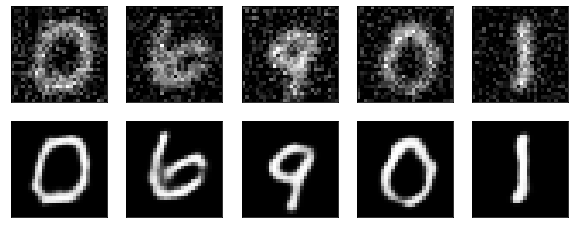

In [34]:
decoded_noisy_blur_imgs = autoencoder.predict(X_test_noisy_blur)
first = 10
n = 5
plt.figure(figsize=(10, 6))
for i in range(n):
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test_noisy_blur[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(3, n, i+n+1)
    plt.imshow(decoded_noisy_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Сравнение восстановленных данных

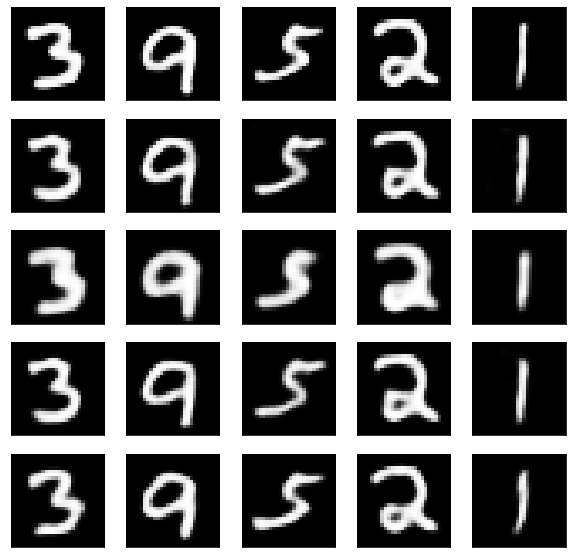

In [35]:
first = 500
n = 5
plt.figure(figsize=(10, 12))
for i in range(n):
    ax = plt.subplot(6, n, i+1)
    plt.imshow(decoded_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
    ax = plt.subplot(6, n, i+n+1)
    plt.imshow(decoded_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+2*n+1)
    plt.imshow(decoded_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+3*n+1)
    plt.imshow(decoded_blur_noisy_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    ax = plt.subplot(6, n, i+4*n+1)
    plt.imshow(decoded_noisy_blur_imgs[i+first].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()